## Import necessary packages


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import seaborn.objects as so
import statsmodels.tsa.arima.model
import statsmodels.api as sm
import sklearn
import tensorflow as tf
import warnings

from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from numpy import array
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from warnings import filterwarnings
filterwarnings('ignore')

## Load Dataset and Prepocessing

In [4]:
data = pd.read_csv('/home/student28/Desktop/AIMS Project/Data/DeathsGH.csv')
data.drop(labels=['Unnamed: 23'],inplace=True, axis=1)
data=data.iloc[:-1]
data.head()

,Age/Period,2010,2010.1,2011,2011.1,2012,2012.1,2013,2013.1,2014,...,2016,2016.1,2017,2017.1,2018,2018.1,2019,2019.1,2020,2020.1
0,40.0,32,19261,32,19843,33.0,20301,31,20663,31.0,...,32.0,20829,32.0,20614,34.0,20342,30.0,20143,29,20063
1,41.0,31,18703,33,19305,32.0,19844,31,20271,34.0,...,32.0,20866,37.0,20793,35.0,20579,33.0,20269,31,20079
2,42.0,34,18294,33,18743,37.0,19311,34,19829,36.0,...,40.0,20778,36.0,20821,38.0,20742,34.0,20492,37,20198
3,43.0,35,17944,39,18330,40.0,18739,39,19287,38.0,...,38.0,20565,41.0,20735,40.0,20763,37.0,20644,36,20413
4,44.0,36,17442,38,17968,38.0,18324,40,18716,39.0,...,40.0,20214,41.0,20536,44.0,20684,46.0,20665,41,20563


## Data Exploration

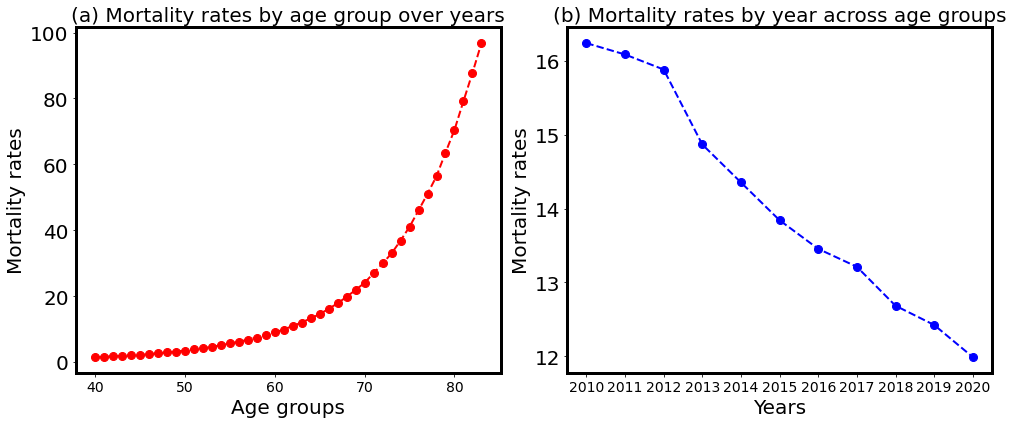

In [5]:
deaths_arr = []
susceptibles_arr = []

for i in range(data.shape[0]):
    deaths_arr.append(np.sum(data.loc[i, '2010':'2020':2]))
    susceptibles_arr.append(np.sum(data.loc[i, '2010.1'::2])) 
mortality = (np.array(deaths_arr)/np.array(susceptibles_arr))*1000

year_mortality = []
year=[]

for i in range(1,len(data.columns)-1 ,2):
    year_mortality.append((np.sum(data[data.columns[i]])/np.sum(data[data.columns[i+1]]))*1000)
    year.append(data.columns[i])
    
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot on the first subplot (left)
ax1.plot(np.array(data["Age/Period"]), mortality, color='red', linestyle='--', marker='o', markersize=8, linewidth=2)
ax1.set_title('(a) Mortality rates by age group over years', fontsize=20)
ax1.set_xlabel('Age groups', fontsize=20)
ax1.set_ylabel('Mortality rates', fontsize=20)

ax1.tick_params(axis='x', labelsize=14)  # Set font size for x-axis tick labels
ax1.tick_params(axis='y', labelsize=20)  # Set font size for y-axis tick labels

# Improve appearance of the box surrounding the plot
ax1.spines['top'].set_linewidth(3) # Set line width of top spine
ax1.spines['right'].set_linewidth(3) # Set line width of right spine
ax1.spines['bottom'].set_linewidth(3) # Set line width of bottom spine
ax1.spines['left'].set_linewidth(3) # Set line width of left spine
ax1.spines['top'].set_color('black') # Set color of top spine
ax1.spines['right'].set_color('black') # Set color of right spine
ax1.spines['bottom'].set_color('black') # Set color of bottom spine
ax1.spines['left'].set_color('black') # Set color of left spine

# Plot on the second subplot (right)
ax2.plot(year, year_mortality, color='blue', linestyle='--', marker='o', markersize=8, linewidth=2)
ax2.set_title('(b) Mortality rates by year across age groups', fontsize=20)
ax2.set_xlabel('Years', fontsize=20)
ax2.set_ylabel('Mortality rates', fontsize=20)

ax2.tick_params(axis='x', labelsize=14)  # Set font size for x-axis tick labels
ax2.tick_params(axis='y', labelsize=20)  # Set font size for y-axis tick labels

# Improve appearance of the box surrounding the plot
ax2.spines['top'].set_linewidth(3) # Set line width of top spine
ax2.spines['right'].set_linewidth(3) # Set line width of right spine
ax2.spines['bottom'].set_linewidth(3) # Set line width of bottom spine
ax2.spines['left'].set_linewidth(3) # Set line width of left spine
ax2.spines['top'].set_color('black') # Set color of top spine
ax2.spines['right'].set_color('black') # Set color of right spine
ax2.spines['bottom'].set_color('black') # Set color of bottom spine
ax2.spines['left'].set_color('black') # Set color of left spine

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## Preparing Data

In [6]:
dfcoly = pd.DataFrame()
for ele in data.columns[1::2]:
    dfcoly[ele] = ele.split(' ')*data.shape[0]
    
l = []
for i in range(len(dfcoly.columns)):
    l.append(dfcoly.to_numpy()[:,i])
years = np.array(l).flatten().reshape(484,1)

new_data = pd.DataFrame(years, columns=['years'])
pd.set_option('display.max_rows', None)
new_data['ages'] = list(data['Age/Period'])*len(dfcoly.columns)
new_data.head()

,years,ages
0,2010,40.0
1,2010,41.0
2,2010,42.0
3,2010,43.0
4,2010,44.0


### Load mortality rates

In [7]:
loader = []
i = 1
while i < len(data.columns):
    loader.append(np.array(data[data.columns[i]])/np.array(data[data.columns[i+1]]))
    i += 2
new_data['m_xt'] = np.array(loader).flatten()
new_data.head()

,years,ages,m_xt
0,2010,40.0,0.001661
1,2010,41.0,0.001657
2,2010,42.0,0.001859
3,2010,43.0,0.001951
4,2010,44.0,0.002064


## Data Exploration

In [8]:
new_data1 = new_data.copy()
new_data1.columns = ['years', 'age groups', 'mortality rates']

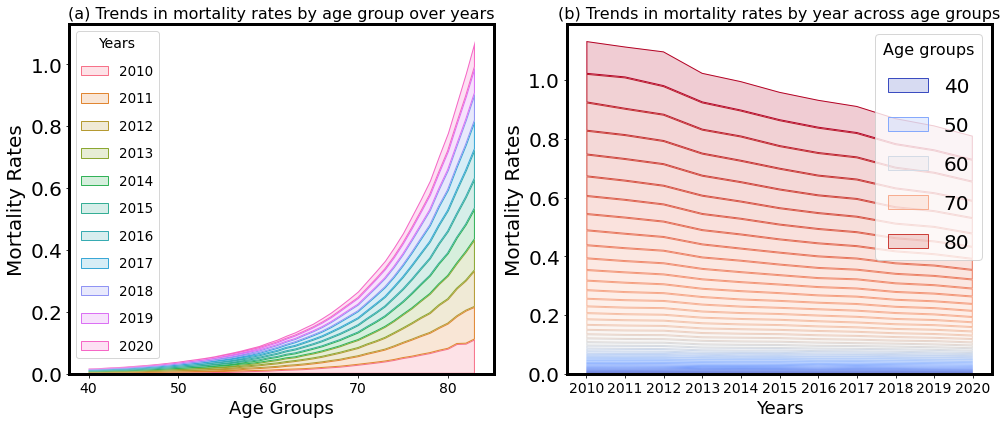

In [9]:
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

plot1 = (
    so.Plot(new_data1, x="age groups", y="mortality rates", color="years")
    .add(so.Area(), so.Stack())
    .on(ax1)  # Specify the axis for the plot
    .plot())

# Remove the existing legend from the figure
legend = fig.legends.pop(0)
# Add a new legend with increased font size
ax1.legend(
    legend.legend_handles, 
    [t.get_text() for t in legend.texts],
    title='Years',
    prop={'size': 13.5},  # Increase font size (adjust as needed)
    title_fontsize=14,       # Font size of the legend title
    labelspacing=1        # Vertical space between labels
)

# Second plot on the second subplot
plot2 = (
    (so.Plot(new_data1, x="years", y="mortality rates", color="age groups")
    .add(so.Area(), so.Stack())
    .scale(color="coolwarm"))
    .on(ax2)
    .plot())

# Remove the existing legend from the figure
legend = fig.legends.pop(0)
# Add a new legend with increased font size
ax2.legend(
    legend.legend_handles, 
    [t.get_text() for t in legend.texts],
    title='Age groups',
    prop={'size': 20},  # Increase font size (adjust as needed)
    title_fontsize=16,       # Font size of the legend title
    labelspacing=1         # Vertical space between labels
)

# Customize the plots as needed
ax1.set_title('(a) Trends in mortality rates by age group over years', fontsize=16)
ax1.set_xlabel('Age Groups', fontsize=18)
ax1.set_ylabel('Mortality Rates', fontsize=20)
# Improve appearance of the box surrounding the plot
ax1.spines['top'].set_linewidth(3) # Set line width of top spine
ax1.spines['right'].set_linewidth(3) # Set line width of right spine
ax1.spines['bottom'].set_linewidth(3) # Set line width of bottom spine
ax1.spines['left'].set_linewidth(3) # Set line width of left spine
ax1.spines['top'].set_color('black') # Set color of top spine
ax1.spines['right'].set_color('black') # Set color of right spine
ax1.spines['bottom'].set_color('black') # Set color of bottom spine
ax1.spines['left'].set_color('black') # Set color of left spine

ax1.tick_params(axis='x', labelsize=14)  # Set font size for x-axis tick labels
ax1.tick_params(axis='y', labelsize=20)  # Set font size for y-axis tick labels

ax2.set_title('(b) Trends in mortality rates by year across age groups', fontsize=16)
ax2.set_xlabel('Years', fontsize=18)
ax2.set_ylabel('Mortality Rates', fontsize=20)
# Improve appearance of the box surrounding the plot
ax2.spines['top'].set_linewidth(3) # Set line width of top spine
ax2.spines['right'].set_linewidth(3) # Set line width of right spine
ax2.spines['bottom'].set_linewidth(3) # Set line width of bottom spine
ax2.spines['left'].set_linewidth(3) # Set line width of left spine
ax2.spines['top'].set_color('black') # Set color of top spine
ax2.spines['right'].set_color('black') # Set color of right spine
ax2.spines['bottom'].set_color('black') # Set color of bottom spine
ax2.spines['left'].set_color('black') # Set color of left spine

ax2.tick_params(axis='x', labelsize=14)  # Set font size for x-axis tick labels
ax2.tick_params(axis='y', labelsize=20)  # Set font size for y-axis tick labels

# Adjust the layout
plt.tight_layout()

### Transform mortality rates into log rates.

In [16]:
new_data['log_mx'] = np.log(new_data['m_xt'])
new_data.head()

,years,ages,m_xt,log_mx
0,2010,40.0,0.001661,-6.400102
1,2010,41.0,0.001657,-6.402452
2,2010,42.0,0.001859,-6.287968
3,2010,43.0,0.001951,-6.239663
4,2010,44.0,0.002064,-6.183117


### Calculating model input parameters ($a_{x}$, $b_{x}$, $k_{t}$)
Calcualte four parameters:
- $a_{x}$ is the average over time of ln($m_{x,t}$) for each age;
- $A_{x,t}$ = ln($m_{x,t}$) - $a_{x}$ (used in SVD);
- $k_{t}$ = ($u_{1,1}$, $u_{2,1}$, ..., $u_{t,1}$) (derived form U from svd($A_{x,t}$));
- $b_{x}$ = ($v_{1,1}$, $v_{1,2}$, ..., $v_{1,x}$) (derived from V* from svd($A_{x,t}$)).

svd($A_{x,t}$) = USV* is the the singular value decomposition.<br>
x denotes age, t - year.

### Matrice Ax

In [17]:
data_Ax = new_data[['ages','log_mx']].groupby('ages').mean('log_mx').reset_index().rename(columns={'log_mx':'ax'})
# Axt
Axt = new_data.merge(data_Ax)
Axt['Axt'] = Axt['log_mx'] - Axt['ax']
Axt = Axt[['years','ages','Axt']]
Axt.head()

,years,ages,Axt
0,2010,40.0,0.072904
1,2010,41.0,0.012700
2,2010,42.0,0.035517
3,2010,43.0,0.007335
4,2010,44.0,-0.006029


## Data Exploration

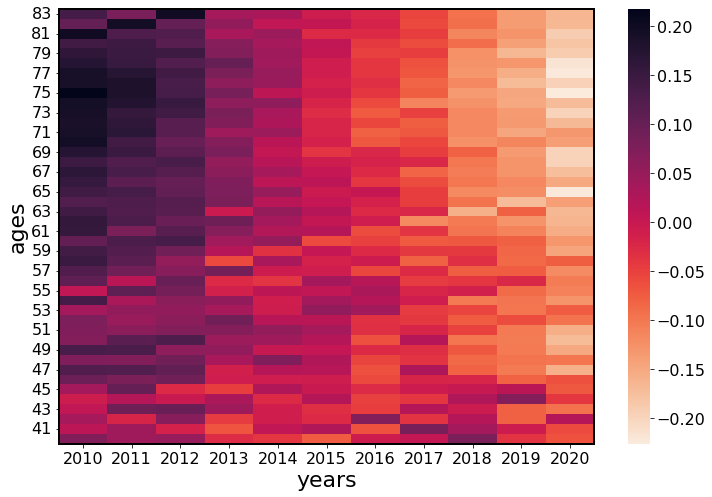

In [18]:
# Assuming Axt is your DataFrame
Axt['ages'] = Axt['ages'].astype(int)

# heatmap
Axt_heatmap = Axt.pivot(columns='years', index='ages', values='Axt').sort_index(ascending = False)
plt.figure(figsize=(12, 8))
sns.heatmap(Axt_heatmap, cmap = 'rocket_r')

# Adjust appearance of the box
ax = plt.gca()
ax.spines['top'].set_visible(True)    # Show the top spine
ax.spines['right'].set_visible(True)  # Show the right spine
ax.spines['bottom'].set_visible(True) # Show the bottom spine
ax.spines['left'].set_visible(True)   # Show the left spine

# Customize appearance of the box
ax.spines['top'].set_linewidth(2)    # Set the line width of top spine
ax.spines['right'].set_linewidth(2)  # Set the line width of right spine
ax.spines['bottom'].set_linewidth(2) # Set the line width of bottom spine
ax.spines['left'].set_linewidth(2)   # Set the line width of left spine

# Increase font size for x and y ticks
plt.xticks(fontsize=16)  # Set x-axis tick font size
plt.yticks(fontsize=16, rotation=0)  # Set y-axis tick font size

# Increase font size for x and y labels
ax.set_xlabel(ax.get_xlabel(), fontsize=22)
ax.set_ylabel(ax.get_ylabel(), fontsize=22)

# Increase font size for the title if any
ax.set_title(ax.get_title(), fontsize=16)

# Customize color bar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Set the font size for color bar ticks

# Show the plot
plt.show()

### Matrice Ax

In [19]:
Axt = Axt.pivot(columns='years', index='ages', values='Axt')
Axt.head()

years,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
ages,,,,,,,,,,,
40,0.072904,0.043135,0.051088,-0.029107,-0.039410,-0.074449,-0.005360,0.005016,0.078923,-0.036409,-0.066331
41,0.012700,0.043540,-0.014769,-0.067808,0.006381,0.026254,-0.064989,0.083698,0.038473,-0.005189,-0.058291
42,0.035517,-0.018583,0.065973,-0.045055,-0.009597,-0.026528,0.070714,-0.036714,0.021155,-0.077945,0.021064
43,0.007335,0.094266,0.097515,0.043373,-0.010115,-0.030881,-0.046762,0.020992,-0.005050,-0.077264,-0.093410
44,-0.006029,0.018327,-0.001292,0.028834,-0.026225,0.020715,-0.048163,-0.039274,0.024162,0.069533,-0.040588


### Compute SVD (Singular Value Decomposition)

In [20]:
U, S, V = np.linalg.svd(Axt.to_numpy())

# extract ax
ax = data_Ax['ax'].to_list()

# extract bx
bx = list(U[:,0]/np.sum(U[:,0]))

# extract kt
# Calculate kt using the SVD components
kt = (V[0, :] * S[0] * np.sum((U[:, 0]))).tolist()

# extract x and t
t = list(range(2010, 2021))
x = list(range(40,84))

### Trend of Alpha_x

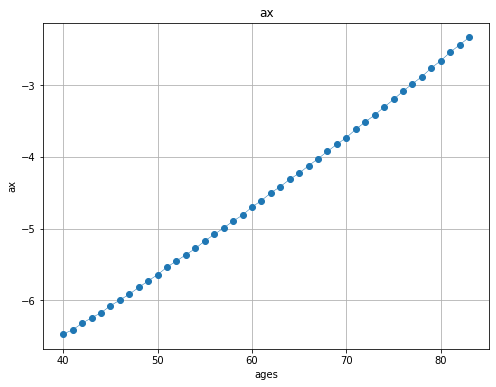

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(x, ax, marker='o', linewidth=0.5, label='$n=2$')
plt.title('ax')
plt.xlabel('ages')
plt.ylabel('ax')
plt.grid(True)
plt.show()

### Trends of Beta_x and kt

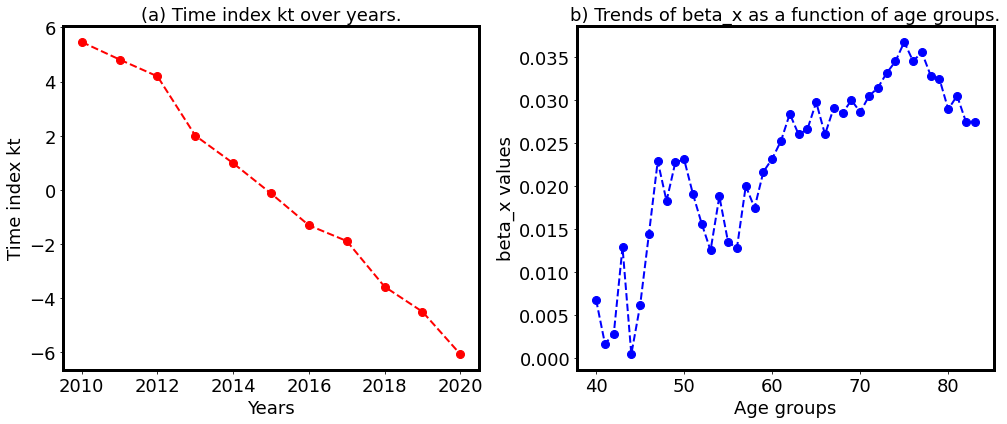

In [22]:
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot on the second subplot (right)
ax1.plot(t, kt, color='red', linestyle='--', marker='o', markersize=8, linewidth=2)
ax1.set_title('(a) Time index kt over years.', fontsize=18)
ax1.set_xlabel('Years', fontsize=18)
ax1.set_ylabel('Time index kt', fontsize=18)

# Improve appearance of the box surrounding the plot
ax1.spines['top'].set_linewidth(3) # Set line width of top spine
ax1.spines['right'].set_linewidth(3) # Set line width of right spine
ax1.spines['bottom'].set_linewidth(3) # Set line width of bottom spine
ax1.spines['left'].set_linewidth(3) # Set line width of left spine
ax1.spines['top'].set_color('black') # Set color of top spine
ax1.spines['right'].set_color('black') # Set color of right spine
ax1.spines['bottom'].set_color('black') # Set color of bottom spine
ax1.spines['left'].set_color('black') # Set color of left spine

ax1.tick_params(axis='x', labelsize=18)  # Set font size for x-axis tick labels
ax1.tick_params(axis='y', labelsize=18)  # Set font size for y-axis tick labels 

# Plot on the first subplot (left)
ax2.plot(x, bx, color='blue', linestyle='--', marker='o', markersize=8, linewidth=2)
ax2.set_title('b) Trends of beta_x as a function of age groups.', fontsize=18)
ax2.set_xlabel('Age groups', fontsize=18)
ax2.set_ylabel('beta_x values', fontsize=18)

# Improve appearance of the box surrounding the plot
ax2.spines['top'].set_linewidth(3) # Set line width of top spine
ax2.spines['right'].set_linewidth(3) # Set line width of right spine
ax2.spines['bottom'].set_linewidth(3) # Set line width of bottom spine
ax2.spines['left'].set_linewidth(3) # Set line width of left spine
ax2.spines['top'].set_color('black') # Set color of top spine
ax2.spines['right'].set_color('black') # Set color of right spine
ax2.spines['bottom'].set_color('black') # Set color of bottom spine
ax2.spines['left'].set_color('black') # Set color of left spine

ax2.tick_params(axis='x', labelsize=18)  # Set font size for x-axis tick labels
ax2.tick_params(axis='y', labelsize=18)  # Set font size for y-axis tick labels

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

### Forecast 𝑘𝑡 using ARIMA Model (𝑝, 𝑑, 𝑞)

In Lee-Carter model 𝑘𝑡 is forecasted using standard univariate ARIMA model to n additional years.

## Data preparation

In [23]:
# Dataframe Years and kt
series = pd.DataFrame(t, columns=['years'])
series1=pd.DataFrame(t, columns=['years'])
series['kt'] = (kt)
seiries = series.values
series = series.set_index('years')
series

,kt
years,
2010,5.460934
2011,4.813927
2012,4.192683
2013,2.003812
2014,0.986085
2015,-0.130399
2016,-1.306840
2017,-1.886319
2018,-3.573089


### Grid Search for Optimizing ARIMA Parameters in Time Series Analysis

In [24]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
                    
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

### Run the Grid Search Process

Remove the comment on the last line to run the Grid Search Process.

In [25]:
# evaluate parameters
p_values = [0,1,2,3,4,5,6,7,8,9,10]
d_values = range(0, 10)
q_values = range(0, 10)
# evaluate_models(series.values, p_values, d_values, q_values) 

## Fit the ARIMA model to the time series kt

In [26]:
AR = ARIMA(series, order=(3,1,5))
model_fitAR = AR.fit()
# summary of fit model
print(model_fitAR.summary())

                               SARIMAX Results                                
Dep. Variable:                     kt   No. Observations:                   11
Model:                 ARIMA(3, 1, 5)   Log Likelihood                  -6.899
Date:                Wed, 19 Jun 2024   AIC                             31.799
Time:                        11:54:58   BIC                             34.522
Sample:                             0   HQIC                            28.811
                                 - 11                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5378      0.832     -0.646      0.518      -2.169       1.094
ar.L2          0.5442      0.577      0.943      0.346      -0.587       1.675
ar.L3          0.9936      0.270      3.684      0.0

## Exploration of Residuals

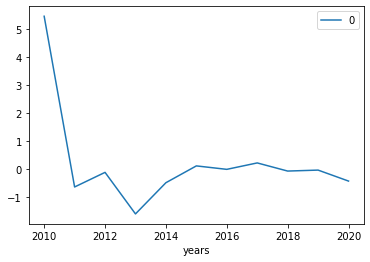

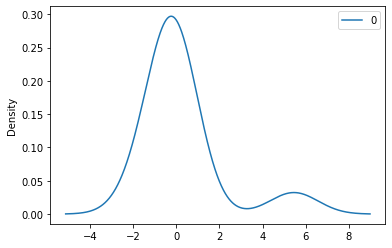

               0
count  11.000000
mean    0.211932
std     1.812630
min    -1.610856
25%    -0.465199
50%    -0.077695
75%     0.045297
max     5.460934


In [27]:
# line plot of residuals
residuals = DataFrame(model_fitAR.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

### Training and Testing ARIMA model using out of sample 70% for training and 30% for testing sets

In [28]:
X = series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

### Predicted kt and expected kt for ARIMA model

In [29]:
for d in range(len(test)):
 model = ARIMA(history, order=(3,1,5))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[d]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

predicted=-1.925213, expected=-1.886319
predicted=-3.615341, expected=-3.573089
predicted=-4.597541, expected=-4.496416
predicted=-5.401419, expected=-6.064378


### Functions for Evaluation Metrics

In [30]:
# Define mean_absolute_percentage_error function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
def evaluate_model(y_true, y_pred, model_name):
    
    # Ensure true_values and predicted_values are initialized
    true_values = np.array(y_true)
    predicted_values = np.array(y_pred)

    if model_name == "ARIMA model":
        true_values, predicted_values = true_values.flatten(), predicted_values.copy()
    
    # Calculate residuals
    residuals = true_values - predicted_values
    
    # Estimate the variance function
    variance = np.var(residuals)

    # Calculate weights using estimated variance
    weights = 1 / variance
    
    # Calculate MSE and MAE
    mse = np.mean(residuals**2)
    mae = np.mean(np.abs(residuals))
    
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    
    # Calculate HMSE and HMAE using weights
    hmse = np.mean((residuals**2) * weights)
    hmae = np.mean(np.abs(residuals) * np.sqrt(weights))
    
    print(f'{model_name} - MSE: {mse:.7f}, MAE: {mae:.7f}, HMSE: {hmse:.7f}, HMAE: {hmae:.7f}, RMSE: {rmse:.7f}, MAPE: {mape:.7f}, R2: {r2:.7f}')  # MSE: {mse:.7f},

In [32]:
evaluate_model(test, predictions, f'ARIMA model') # 

ARIMA model - MSE: 0.1132598, MAE: 0.2113072, HMSE: 1.1461412, HMAE: 0.6721952, RMSE: 0.3365410, MAPE: 4.1063452, R2: 0.9505301


### Plot the actual and predicted values of kt using ARIMA model for visual comparison

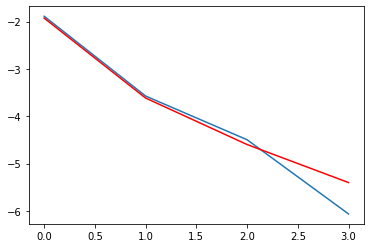

In [33]:
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Forecasting kt for ARIMA model

In [34]:
# Make Forecasting
forecast_steps=10                              
forecast = model_fit.forecast(steps=forecast_steps)

### Forecasts values of kt for the future using ARIMA model

In [35]:
print("Forecasted values:", forecast)

Forecasted values: [ -5.40141877  -7.1271855   -7.75214992  -9.09375147 -10.47650658
 -11.08397835 -12.75693729 -13.68420492 -14.61052408 -16.2837883 ]


### ARIMA Model : Calculate forecasted age-specific mortality
Use the forecasted $k_{t+n}$, with the original $b_{x}$, and $a_{x}$ to calculate the forecasted mortality rate for each age:<br>
$m_{x,t+n}$  = exp($a_{x}$ + $k_{t+n}$$b_{x}$).

In [36]:
def mxforcasted_ages(New_kt):
    mx_forecasted = pd.DataFrame()
    for i in range(len(New_kt)):
        mx_forecasted_i = []
        for j in range(len(x)):
            mx_forecasted_i.append(np.exp(ax[j] + New_kt[i] * bx[j]))
        mx_forecasted_i = pd.DataFrame({'ages': x, 'm_xt':mx_forecasted_i})
        mx_forecasted_i['years'] = 2010 + i
        mx_forecasted = pd.concat([mx_forecasted, mx_forecasted_i])

    mx_forecasted['forecasted'] = 1
    mx_forecasted = mx_forecasted[['years','ages','m_xt','forecasted']]
    
    real_data = new_data[['years', 'ages','m_xt']]
    real_data['forecasted'] = 0
    real_data = real_data[['years','ages','m_xt','forecasted']]
    return real_data, mx_forecasted

### Compare Actual and Forcasted data

Compare forecasted values with real values of mx. We can also calculate the deviations of the real data from the forecasted. The measure might be called 'excess mortality'.

In [37]:
# compare real and forecasted values
real_data, mx_forecasted=mxforcasted_ages(kt[:7]+predictions)
result = pd.concat([real_data, mx_forecasted]).reset_index()[['years','ages','m_xt','forecasted']]
result['log_mx'] = np.log(result['m_xt'])
result['years'] = result['years'].astype(float)
result.head()

,years,ages,m_xt,forecasted,log_mx
0,2010.0,40.0,0.001661,0,-6.400102
1,2010.0,41.0,0.001657,0,-6.402452
2,2010.0,42.0,0.001859,0,-6.287968
3,2010.0,43.0,0.001951,0,-6.239663
4,2010.0,44.0,0.002064,0,-6.183117


### Function Plots Actual and Forecasted values

In [38]:
def plot_kt(new_data1, new_data2):
    # Create a figure with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    # Define custom legend handles
    actual_patch = mpatches.Patch(color='blue', label='kt Actual')
    predicted_patch = mpatches.Patch(color='red', label='kt Predicted')

    # First plot on the first subplot
    sns.lineplot(data=new_data1, x="ages", y='log_mx', hue=new_data1["years"].astype(int), ax=ax1)
    sns.lineplot(data=new_data1, x="ages", y='log_mx', hue=new_data1["forecasted"].map({0: 'Actual', 1: 'Predicted'}), palette={'Actual': 'blue', 'Predicted': 'red'}, ax=ax1)
    ax1.set_title('(a) ' + str(new_data1["years"].iloc[1].astype(int)), fontsize=30)
    ax1.set_xlabel('Age Groups', fontsize=30)
    ax1.set_ylabel('log mortality rates', fontsize=30)
    #
    # Customize the legend
    legend1 = ax1.legend(handles=[actual_patch, predicted_patch], title='Year ' + str(new_data1["years"].iloc[1].astype(int)), loc='upper left', frameon=True, title_fontsize=18, fontsize=18)
    frame1 = legend1.get_frame()
    frame1.set_facecolor('lightgray')  # Set the background color of the legend
    ax1.tick_params(axis='x', labelsize=30)  # Set font size for x-axis tick labels
    ax1.tick_params(axis='y', labelsize=30)  # Set font size for y-axis tick labels

    # Improve appearance of the box surrounding the plot
    ax1.spines['top'].set_linewidth(3) # Set line width of top spine
    ax1.spines['right'].set_linewidth(3) # Set line width of right spine
    ax1.spines['bottom'].set_linewidth(3) # Set line width of bottom spine
    ax1.spines['left'].set_linewidth(3) # Set line width of left spine
    ax1.spines['top'].set_color('black') # Set color of top spine
    ax1.spines['right'].set_color('black') # Set color of right spine
    ax1.spines['bottom'].set_color('black') # Set color of bottom spine
    ax1.spines['left'].set_color('black') # Set color of left spine

    # First plot on the first subplot
    sns.lineplot(data=new_data2, x="ages", y='log_mx', hue=new_data2["years"].astype(int), ax=ax2)
    sns.lineplot(data=new_data2, x="ages", y='log_mx', hue=new_data2["forecasted"].map({0: 'Actual', 1: 'Predicted'}), palette={'Actual': 'blue', 'Predicted': 'red'}, ax=ax2)
    ax2.set_title('(b) ' + str(new_data2["years"].iloc[1].astype(int)), fontsize=30)
    ax2.set_xlabel('Age Groups', fontsize=30)
    ax2.set_ylabel('log mortality rates', fontsize=30)
    
    # Customize the legend
    legend2 = ax2.legend(handles=[actual_patch, predicted_patch], title='Year ' + str(new_data2["years"].iloc[1].astype(int)), loc='upper left', frameon=True, title_fontsize=18, fontsize=18)
    frame2 = legend2.get_frame()
    frame2.set_facecolor('lightgray')  # Set the background color of the legend
    ax2.tick_params(axis='x', labelsize=30)  # Set font size for x-axis tick labels
    ax2.tick_params(axis='y', labelsize=30)  # Set font size for y-axis tick labels

    # Improve appearance of the box surrounding the plot
    ax2.spines['top'].set_linewidth(3) # Set line width of top spine
    ax2.spines['right'].set_linewidth(3) # Set line width of right spine
    ax2.spines['bottom'].set_linewidth(3) # Set line width of bottom spine
    ax2.spines['left'].set_linewidth(3) # Set line width of left spine
    ax2.spines['top'].set_color('black') # Set color of top spine
    ax2.spines['right'].set_color('black') # Set color of right spine
    ax2.spines['bottom'].set_color('black') # Set color of bottom spine
    ax2.spines['left'].set_color('black') # Set color of left spine

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

### Compare Actual and Forecasted values using ARIMA model

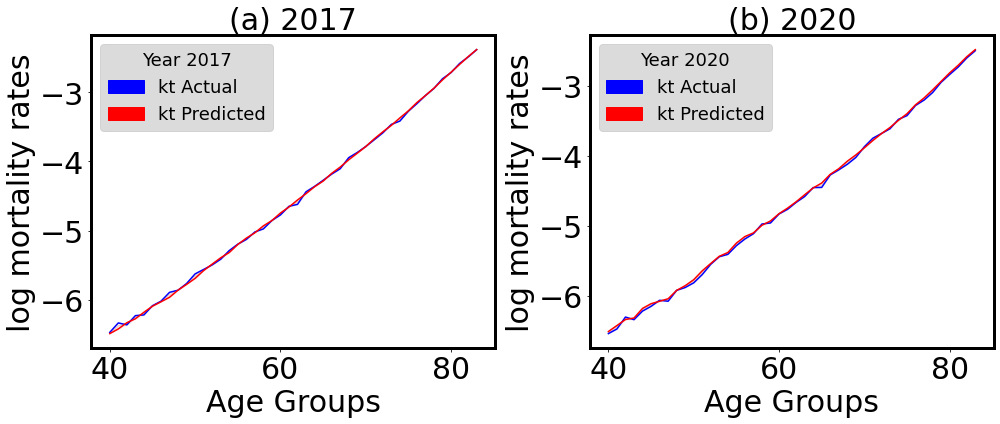

In [39]:
sub_years1 = result[result['years'] == 2017]
sub_years2 = result[result['years'] == 2020]
plot_kt(sub_years1, sub_years2) #, sub_years3, sub_years4)

### Excess mortality by age
Calculate relative (observed to expected mx ratio) and absoule (difference between observed and expected mx per 1000 person-years) values of excess mortality.

In [40]:
result_0 = result[(result['years'].astype(int) > 2017) & (result['forecasted'] ==0)]
result_1 = result[(result['years'].astype(int) > 2017) & (result['forecasted'] ==1)]
result_1.head()

,years,ages,m_xt,forecasted,log_mx
836,2018.0,40.0,0.001507,1,-6.497347
837,2018.0,41.0,0.001627,1,-6.421163
838,2018.0,42.0,0.001776,1,-6.333298
839,2018.0,43.0,0.001848,1,-6.293499
840,2018.0,44.0,0.002073,1,-6.178608


In [41]:
# calculate values of excess mortality
em = result_1.merge(result_0, on = ['years','ages'])[['years','ages','m_xt_x','m_xt_y']].rename(
    columns = {
        'm_xt_x' : 'mx_expected',
        'm_xt_y' : 'mx_observed'
    }
)
em['excess_mort_abs'] = (em['mx_observed'] - em['mx_expected']) * 1000 # per 1000 person-years
em['excess_mort_rel'] = em['mx_observed'] / em['mx_expected'] # ratio
em.head()

,years,ages,mx_expected,mx_observed,excess_mort_abs,excess_mort_rel
0,2018.0,40.0,0.001507,0.001671,0.163986,1.108785
1,2018.0,41.0,0.001627,0.001701,0.074000,1.045489
2,2018.0,42.0,0.001776,0.001832,0.055865,1.031453
3,2018.0,43.0,0.001848,0.001927,0.078222,1.042321
4,2018.0,44.0,0.002073,0.002127,0.053935,1.026014


### Visualize excess mortality

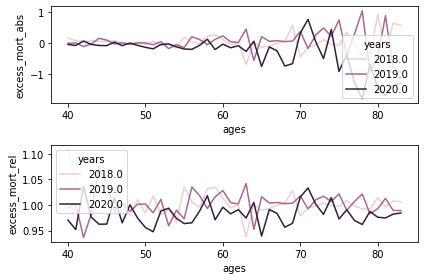

In [42]:
plt.subplot(2, 1, 1)
sns.lineplot(data = em, x = 'ages', y = 'excess_mort_abs', hue = 'years')

plt.subplot(2, 1, 2)
sns.lineplot(data = em, x = 'ages', y = 'excess_mort_rel', hue = 'years')

plt.tight_layout()

## Deep Learning Techniques and Stacking ensemble

### Data Preparation

In [43]:
data = kt
# Convert the list to a NumPy array and reshape for the scaler
data = np.array(data).reshape(-1, 1)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create dataset with look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Look back 3 values to predict the next one
look_back = 3
X, Y = create_dataset(scaled_data, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Initialize time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

### Deep learning techniques

In [44]:
# Function to build and compile LSTM model
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(units=50,  input_shape=input_shape))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Function to build and compile GRU model
def build_gru(input_shape):
    model = Sequential()
    model.add(GRU(units=25, input_shape=input_shape))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Function to build and compile Bidirectional LSTM model
def build_blstm(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=25, input_shape=input_shape)))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Function to build and compile Bidirectional GRU model
def build_bgru(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(units=25,  input_shape=input_shape)))
    model.add(Dropout(0.2)) 
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

### Meta-learner

In [45]:
def meta_learner(Y, stacked_predictions_train):
    # Define GLM model with specified hyperparameters
    glm_model = sm.GLM(Y, stacked_predictions_train, family=sm.families.Gaussian())
    # Fit GLM model
    meta_model = glm_model.fit(maxiter=50, tol=0)
    # Predict using meta-model for all data points
    meta_predictions_train = meta_model.predict(stacked_predictions_train)
    
    return meta_predictions_train, meta_model

### Train and validate deep learning techniques using Cross-validation

In [60]:
# Placeholder for stacked predictions
stacked_predictions_train = np.zeros((X.shape[0], 4)) # 4 is the number of base models in the stack ensemble
stacked_predictions_test = []

# Lists to store y_pred and y_test for each iteration
y_lstm_preds , y_lstm_tests = [], []
y_gru_preds, y_gru_tests = [],[]
y_blstm_preds, y_blstm_tests = [], []
y_bgru_preds, y_bgru_tests = [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Train LSTM model
    lstm_model = build_lstm(input_shape=(look_back, 1))
    lstm_model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
    lstm_pred_train = lstm_model.predict(X_train)
    lstm_pred_test = lstm_model.predict(X_test)
    # Convert the 2D array to a 1D array and then to a Python list
    lstm_pred_test= np.array(lstm_pred_test)
    y_lstm_preds.append(lstm_pred_test.flatten()[0])
    y_lstm_tests.append(Y_test.flatten()[0])

    # Train GRU model
    gru_model = build_gru(input_shape=(look_back, 1))
    gru_model.fit(X_train, Y_train, epochs=20, batch_size=32,  validation_split=0.2, verbose=0)
    gru_pred_train = gru_model.predict(X_train)
    gru_pred_test = gru_model.predict(X_test)
    # Convert the 2D array to a 1D array and then to a Python list
    gru_pred_test= np.array(gru_pred_test)
    y_gru_preds.append(gru_pred_test.flatten()[0])
    y_gru_tests.append(Y_test.flatten()[0])

    # Train BLSTM model
    blstm_model = build_blstm(input_shape=(look_back, 1))
    blstm_model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
    blstm_pred_train = blstm_model.predict(X_train)
    blstm_pred_test = blstm_model.predict(X_test)
    # Convert the 2D array to a 1D array and then to a Python list
    blstm_pred_test= np.array(blstm_pred_test)
    y_blstm_preds.append(blstm_pred_test.flatten()[0])
    y_blstm_tests.append(Y_test.flatten()[0])
 
    # Train BGRU model
    bgru_model = build_bgru(input_shape=(look_back, 1))
    bgru_model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
    bgru_pred_train = bgru_model.predict(X_train)
    bgru_pred_test = bgru_model.predict(X_test)
    # Convert the 2D array to a 1D array and then to a Python list
    bgru_pred_test= np.array(bgru_pred_test)
    y_bgru_preds.append(bgru_pred_test.flatten()[0])
    y_bgru_tests.append(Y_test.flatten()[0])

    # Stacking predictions
    stacked_predictions_train[train_index] = np.hstack([lstm_pred_train, gru_pred_train, blstm_pred_train, bgru_pred_train])
    stacked_predictions_test.append(np.hstack([lstm_pred_test, gru_pred_test, blstm_pred_test, bgru_pred_test]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9

### Calculate average metrics for cross-validation on deep learning techniques

In [61]:
evaluate_model(y_lstm_tests, y_lstm_preds, f'LSTM')
evaluate_model(y_gru_tests, y_gru_preds, f'GRU')
evaluate_model(y_blstm_tests, y_blstm_preds, f'BLSTM')
evaluate_model(y_bgru_tests, y_bgru_preds, f'BGRU')

LSTM - MSE: 0.0098000, MAE: 0.0711216, HMSE: 1.2264890, HMAE: 0.7956482, RMSE: 0.0989947, MAPE: inf, R2: 0.5655646
GRU - MSE: 0.0174208, MAE: 0.1079393, HMSE: 1.0914402, HMAE: 0.8543691, RMSE: 0.1319879, MAPE: inf, R2: 0.2277302
BLSTM - MSE: 0.0161587, MAE: 0.1058354, HMSE: 1.0038294, HMAE: 0.8341757, RMSE: 0.1271169, MAPE: inf, R2: 0.2836789
BGRU - MSE: 0.0387216, MAE: 0.1599350, HMSE: 1.4939525, HMAE: 0.9934258, RMSE: 0.1967780, MAPE: inf, R2: -0.7165409


### Fit and assess the stack ensemble-4

In [62]:
meta_predictions4, meta_model4 = meta_learner(Y, stacked_predictions_train)
evaluate_model(Y, meta_predictions4, f'Stacked Ensemble-4')

Stacked Ensemble-4 - MSE: 0.0003070, MAE: 0.0108331, HMSE: 1.0000009, HMAE: 0.6183132, RMSE: 0.0175205, MAPE: nan, R2: 0.9939445


### Predicted kt and expected kt for stack ensemble-4

In [63]:
# Inverse transform the actual and predicted data
actual_data = scaler.inverse_transform(Y.reshape(-1, 1))
predicted_data = scaler.inverse_transform(meta_predictions4.reshape(-1, 1))
predicted_data_stack4=predicted_data
# Print actual and predicted values
for actual, predicted in zip(actual_data, predicted_data):
    print(f"Actual: {actual[0]:.6f}, Predicted: {predicted[0]:.6f}")

Actual: 2.003812, Predicted: 1.977916
Actual: 0.986085, Predicted: 0.978799
Actual: -0.130399, Predicted: 0.019129
Actual: -1.306840, Predicted: -1.277722
Actual: -1.886319, Predicted: -2.331847
Actual: -3.573089, Predicted: -3.251564
Actual: -4.496416, Predicted: -4.516375
Actual: -6.064378, Predicted: -6.064378


### Plot the actual and predicted values of kt for visual comparison

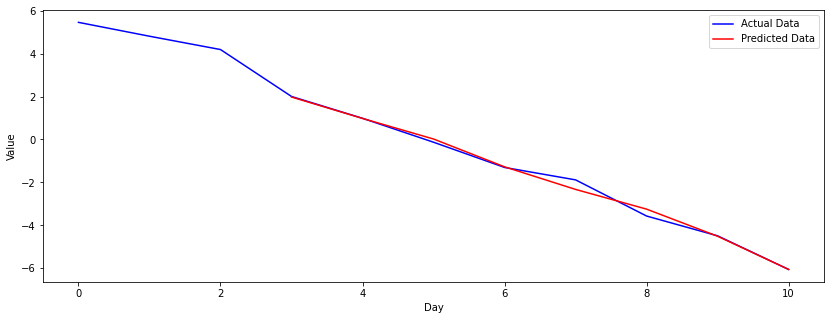

In [64]:
plt.figure(figsize=(14, 5))
plt.plot(range(len(data)), data, color='blue', label='Actual Data')
plt.plot(range(look_back, len(predicted_data) + look_back), predicted_data, color='red', label='Predicted Data')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.show()

### Forecasting kt for stack ensemble-4

In [65]:
# Placeholder for future predictions
future_predictions = np.zeros((10, 4))  # Forecasting 10 future steps and 4 base models

# Use the last available data point as the initial input for forecasting
last_input = scaled_data[-look_back:].reshape(1, look_back, 1)

# Generate predictions for each future step
for i in range(10):
    # Predict using each base model
    lstm_pred = lstm_model.predict(last_input)
    gru_pred = gru_model.predict(last_input)
    blstm_pred = blstm_model.predict(last_input)
    bgru_pred = bgru_model.predict(last_input)

    # Stack the predictions
    stacked_pred = np.hstack([lstm_pred, gru_pred, blstm_pred, bgru_pred])
    future_predictions[i] = stacked_pred

    # Update last_input for the next step
    last_input = np.roll(last_input, -1)
    last_input[-1][-1] = future_predictions[i][0]  # Assuming the first prediction from LSTM for the next step
# Predict using meta-model for future predictions
meta_future_predictions = meta_model4.predict(future_predictions)

# Inverse transform the predicted values for future predictions
predicted_future_data = scaler.inverse_transform(meta_future_predictions.reshape(-1, 1))
forecast_stack4 = predicted_future_data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

### Print the forecasted values of kt for the future using stack ensemble-4

In [66]:
for i, predicted_value in enumerate(forecast_stack4):
    print(f"Forecast for step {i+1} ahead: {predicted_value[0]:.6f}")

Forecast for step 1 ahead: -7.198230
Forecast for step 2 ahead: -7.287843
Forecast for step 3 ahead: -7.417034
Forecast for step 4 ahead: -6.701084
Forecast for step 5 ahead: -6.684266
Forecast for step 6 ahead: -6.628178
Forecast for step 7 ahead: -6.539730
Forecast for step 8 ahead: -6.526750
Forecast for step 9 ahead: -6.510310
Forecast for step 10 ahead: -6.497460


## Evaluation of Others Stack Ensemble Models

### Fit and assess the stack ensemble-2

In [67]:
meta_predictions2, meta_model2 = meta_learner(Y, stacked_predictions_train[:, :2])
evaluate_model(Y, meta_predictions2, f'Stacked Ensemble-2')

Stacked Ensemble-2 - MSE: 0.0012506, MAE: 0.0283844, HMSE: 1.0021155, HMAE: 0.8034866, RMSE: 0.0353639, MAPE: nan, R2: 0.9753293


### Predicted kt and expected kt for stack ensemble-2

In [68]:
# Inverse transform the actual and predicted data
actual_data = scaler.inverse_transform(Y.reshape(-1, 1))
predicted_data = scaler.inverse_transform(meta_predictions2.reshape(-1, 1))
predicted_data_stack2=predicted_data

# Print actual and predicted values
for actual, predicted in zip(actual_data, predicted_data):
    print(f"Actual: {actual[0]:.6f}, Predicted: {predicted[0]:.6f}")

Actual: 2.003812, Predicted: 1.256342
Actual: 0.986085, Predicted: 1.291969
Actual: -0.130399, Predicted: 0.511888
Actual: -1.306840, Predicted: -1.404522
Actual: -1.886319, Predicted: -2.274818
Actual: -3.573089, Predicted: -3.422337
Actual: -4.496416, Predicted: -4.211876
Actual: -6.064378, Predicted: -6.064378


### Plot the actual and predicted values of kt for visual comparison

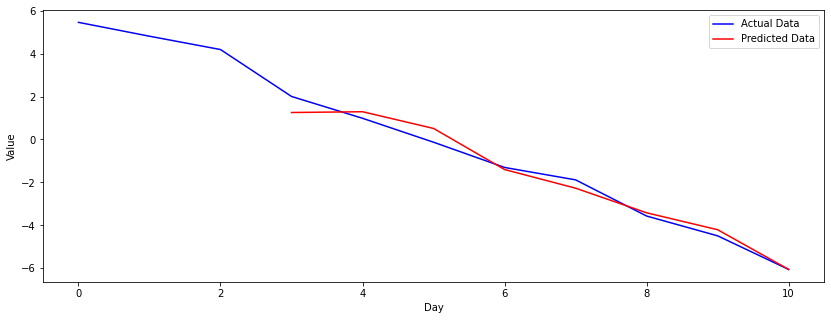

In [69]:
# Plot the actual and predicted values for visual comparison
plt.figure(figsize=(14, 5))
plt.plot(range(len(data)), data, color='blue', label='Actual Data')
plt.plot(range(look_back, len(predicted_data) + look_back), predicted_data, color='red', label='Predicted Data')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.show()

### Fit and assess the stack ensemble-3

In [70]:
meta_predictions3, meta_model3 = meta_learner(Y, stacked_predictions_train[:, :3])
evaluate_model(Y, meta_predictions3, f'Stacked Ensemble-2')

Stacked Ensemble-2 - MSE: 0.0003075, MAE: 0.0103759, HMSE: 1.0000001, HMAE: 0.5917414, RMSE: 0.0175346, MAPE: nan, R2: 0.9939347


### Predicted kt and expected kt for stack ensemble-3

In [71]:
# Inverse transform the actual and predicted data
actual_data = scaler.inverse_transform(Y.reshape(-1, 1))
predicted_data = scaler.inverse_transform(meta_predictions3.reshape(-1, 1))
predicted_data_stack3=predicted_data
# Print actual and predicted values
for actual, predicted in zip(actual_data, predicted_data):
    print(f"Actual: {actual[0]:.6f}, Predicted: {predicted[0]:.6f}")

Actual: 2.003812, Predicted: 1.984794
Actual: 0.986085, Predicted: 0.986320
Actual: -0.130399, Predicted: 0.013352
Actual: -1.306840, Predicted: -1.289046
Actual: -1.886319, Predicted: -2.339105
Actual: -3.573089, Predicted: -3.256340
Actual: -4.496416, Predicted: -4.502770
Actual: -6.064378, Predicted: -6.064378


### Plot the actual and predicted values of kt for visual comparison

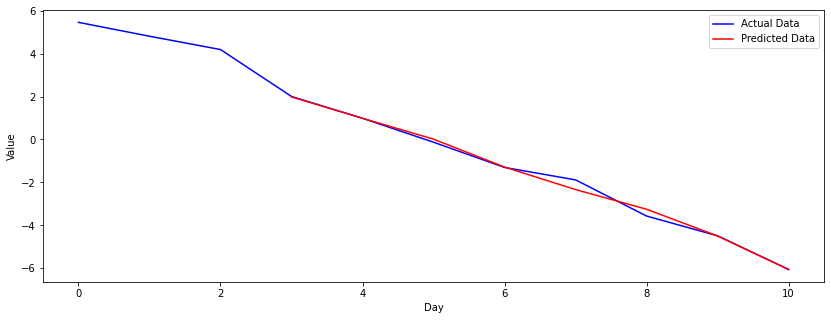

In [72]:
# Plot the actual and predicted values for visual comparison
plt.figure(figsize=(14, 5))
plt.plot(range(len(data)), data, color='blue', label='Actual Data')
plt.plot(range(look_back, len(predicted_data) + look_back), predicted_data, color='red', label='Predicted Data')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.show()

### Compare Actual and Forecasted values using stack ensemble models

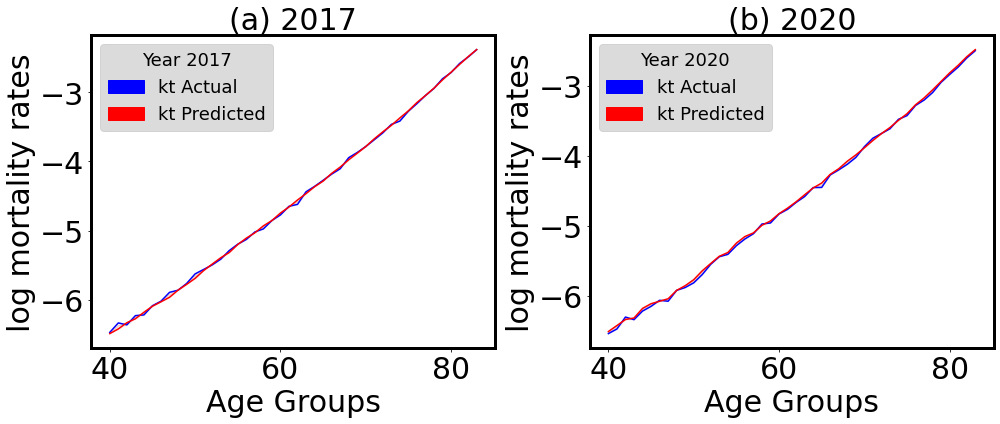

In [73]:
new_data1 = pd.DataFrame(result[result['years'] == 2017])
new_data2 = pd.DataFrame(result[result['years'] == 2020])
plot_kt(new_data1, new_data2)

### Comparative analysis of Actual, Preducted, and Forecast kt between ARIMA model and stack ensemble-4

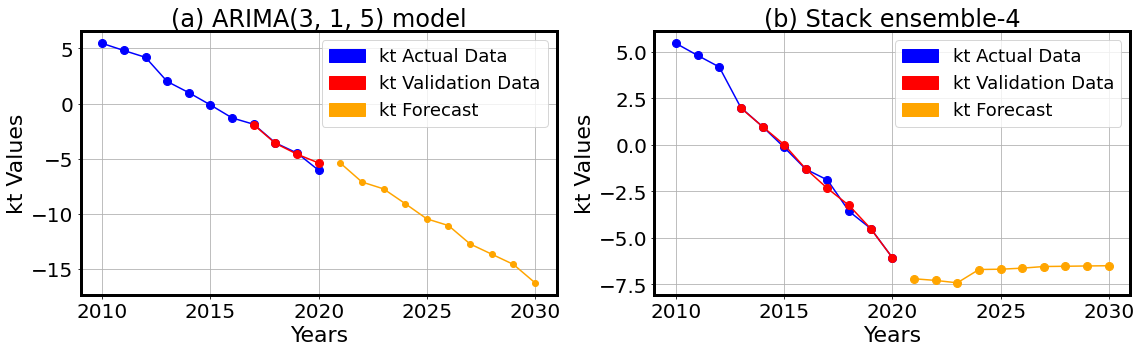

In [74]:
# Define custom legend handles
actual_patch = mpatches.Patch(color='blue', label='kt Actual Data')
predicted_patch = mpatches.Patch(color='red', label='kt Validation Data')
validation_patch = mpatches.Patch(color='orange', label='kt Forecast')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# First plot
axs[0].plot(list(range(2010, 2021)), kt, color='blue', linestyle='-', marker='o', markersize=8, linewidth=1.5)
axs[0].plot(range(2021, 2031), forecast, color='orange', linestyle='-', marker='o', linewidth=1.5)
axs[0].plot(list(range(2017, 2021)), predictions, color='red', linestyle='-', marker='o', markersize=8, linewidth=1.5)
axs[0].set_xlabel('Years', fontsize=22)
axs[0].set_ylabel('kt Values', fontsize=22)
axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
axs[0].grid(True)
axs[0].legend(handles=[actual_patch, predicted_patch, validation_patch], fontsize=18)
axs[0].set_title('(a) ARIMA(3, 1, 5) model', fontsize=24)
# Customize axes appearance
for spine in axs[0].spines.values():
    spine.set_linewidth(3)
    spine.set_color('black')

# Second plot
axs[1].plot(list(range(2010, 2021)), data, color='blue', linestyle='-', marker='o', markersize=8, linewidth=1.5)
axs[1].plot(range(2021,  2031), forecast_stack4, color='orange', linestyle='-', marker='o', markersize=8, linewidth=1.5)
axs[1].plot(range(2013, 2021), predicted_data, color='red', linestyle='-', marker='o', markersize=8, linewidth=1.5)
axs[1].set_xlabel('Years', fontsize=22)
axs[1].set_ylabel('kt Values', fontsize=22)
axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
axs[1].grid(True)
axs[1].legend(handles=[actual_patch, predicted_patch, validation_patch], fontsize=18)
axs[1].set_title('(b) Stack ensemble-4', fontsize=24)
# Customize axes appearance
for spine in axs[1].spines.values():
    spine.set_linewidth(3)
    spine.set_color('black')

# Show the plot
plt.tight_layout()
plt.show()


### Comparative analysis of Forecast kt between ARIMA model and stack ensemble-4

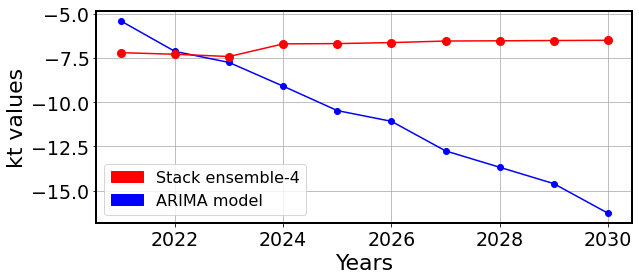

In [76]:
# Define custom legend handles
validation_patch = mpatches.Patch(color='blue', label='ARIMA model')
predicted_patch = mpatches.Patch(color='red', label='Stack ensemble-4')

# Plot the data
plt.figure(figsize=(9, 4))
plt.plot(range(2021, 2031), forecast, color='blue', linestyle='-', marker='o', linewidth=1.5)
plt.plot(range(2021, 2031), forecast_stack4, color='red', linestyle='-', marker='o', markersize=8, linewidth=1.5)
plt.tick_params(axis='x', labelsize=19)
plt.tick_params(axis='y', labelsize=19)
plt.grid(True)

# Add axis labels
plt.xlabel('Years', fontsize=22)
plt.ylabel('kt values', fontsize=22)

# Customize the legend
plt.legend(handles=[predicted_patch, validation_patch], fontsize=16)

# Customize the plot appearance
ax = plt.gca()  # Get current axis

# Improve appearance of the box surrounding the plot
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_linewidth(2)  # Set line width of spine
    ax.spines[spine].set_color('black')  # Set color of spine

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()